# Post-Training Quantization: Deployment Comparison

This notebook simulates the **standard ML deployment workflow**:

1. **Train** both models in **FP32** (full precision) — for maximum training stability
2. **Quantize** both to **FP16** — for efficient deployment
3. **Compare** the quantized versions — what actually gets deployed

## Motivation

In production ML pipelines:
- **Training**: FP32 ensures numerical stability and reproducibility
- **Deployment**: FP16 reduces memory footprint and enables tensor core acceleration

This comparison answers: **When both models are quantized for deployment, which architecture performs better?**

## Models Compared (Post-Quantization)

| Model | Trained In | Deployed As | Size |
|-------|------------|-------------|------|
| Baseline | FP32 | **FP16** | ~50 MB |
| Recurrent | FP32 | **FP16** | ~21 MB |

The key question: Does the recurrent architecture's weight sharing make it more or less sensitive to quantization?


In [1]:
import torch
import torch.nn as nn
import torch.quantization as quant
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.insert(0, os.path.abspath('..'))

from models.baseline import BaselineModel, BaselineConfig
from models.recurrent import RecurrentModel, RecurrentConfig
from training.utils.data_loader import prepare_sst2_data, load_tokenizer
from evaluation.eval import ModelEvaluator, compute_model_metrics

# Set device - use GPU for all models (FP32 and FP16)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    # Check FP16 support
    if torch.cuda.get_device_capability(0)[0] >= 7:
        print("Tensor Cores available for FP16 acceleration!")


Using device: cuda
PyTorch version: 2.7.0+cu128
GPU: NVIDIA GeForce RTX 5090
CUDA version: 12.8
Tensor Cores available for FP16 acceleration!


## Model Configurations

Using the same configurations as in the main experiments.


In [ ]:
# Model configurations for quantization test
# Both models use SAME WIDTH (384) to isolate effect of recurrent architecture on quantization
# Baseline: 6 distinct layers (~10M params)
# Recurrent: 3 shared layers × 2 iterations = 6 effective depth (~5M params due to weight sharing)
BASELINE_CONFIG = BaselineConfig(
    vocab_size=30522,
    hidden_size=384,
    num_hidden_layers=6,
    num_attention_heads=6,
    intermediate_size=1536,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=128,
    num_labels=2,
    use_flash_attention=True,
    use_swiglu=True,
    use_rope=True,
    use_rms_norm=True
)

RECURRENT_CONFIG = RecurrentConfig(
    vocab_size=30522,
    hidden_size=384,          # Same width as baseline for fair quantization comparison
    num_hidden_layers=3,      # 3 layers × 2 iterations = 6 effective depth
    recurrent_depth=2,
    num_attention_heads=6,    # Same as baseline
    intermediate_size=1536,   # Same as baseline
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=128,
    num_labels=2,
    residual_scale=0.5,
    use_flash_attention=True,
    use_swiglu=True,
    use_rope=True,
    use_rms_norm=True
)

print("Configurations loaded")


Configurations loaded


## Load SST-2 Data


In [3]:
# Load tokenizer and data
tokenizer = load_tokenizer('bert-base-uncased')
train_loader, val_loader, test_loader = prepare_sst2_data(
    data_dir='../data/processed',
    tokenizer=tokenizer,
    batch_size=32,
    max_length=128
)

print(f"Test set size: {len(test_loader) * 16} samples")


Loaded 54576 samples from ../data/processed\sst2_train.pkl
Loaded 6822 samples from ../data/processed\sst2_val.pkl
Loaded 6823 samples from ../data/processed\sst2_test.pkl
Test set size: 3424 samples


## Step 1: Initialize and Train Models (FP32)

Train both models in FP32 for 5 epochs with early stopping, then use trained weights for quantization comparison.


In [4]:
# Initialize models (FP32)
baseline_model = BaselineModel(BASELINE_CONFIG)
recurrent_model = RecurrentModel(RECURRENT_CONFIG)

# Move to GPU
baseline_model = baseline_model.to(device)
recurrent_model = recurrent_model.to(device)

# Print model sizes
def get_model_size(model):
    """Get model size in MB"""
    param_size = sum(p.nelement() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.nelement() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / 1024 / 1024

def count_parameters(model):
    """Count total parameters"""
    return sum(p.numel() for p in model.parameters())

print(f"Baseline Model:")
print(f"  Parameters: {count_parameters(baseline_model):,}")
print(f"  Size: {get_model_size(baseline_model):.2f} MB")
print(f"\nRecurrent Model:")
print(f"  Parameters: {count_parameters(recurrent_model):,}")
print(f"  Size: {get_model_size(recurrent_model):.2f} MB")


Baseline Model:
  Parameters: 25,912,706
  Size: 98.85 MB

Recurrent Model:
  Parameters: 18,817,538
  Size: 71.78 MB


In [7]:
# Import simple training function
from training import train_model

# Training configuration
TRAIN_CONFIG = {
    'num_epochs': 5,
    'learning_rate': 3e-5,
    'patience': 3,
    'min_delta': 0.001,
    'save_dir': '../checkpoints'
}

print("Training config:", TRAIN_CONFIG)


Training config: {'num_epochs': 5, 'learning_rate': 3e-05, 'patience': 3, 'min_delta': 0.001, 'save_dir': '../checkpoints'}


In [8]:
# Train both models in FP32
print("=" * 60)
print("TRAINING PHASE: Both models trained in FP32")
print("=" * 60)

# Train baseline model
print("\n--- Training Baseline Model ---")
baseline_history = train_model(
    model=baseline_model,
    train_loader=train_loader,
    val_loader=val_loader,
    name='sst-baseline',
    **TRAIN_CONFIG
)

# Train recurrent model
print("\n--- Training Recurrent Model ---")
recurrent_history = train_model(
    model=recurrent_model,
    train_loader=train_loader,
    val_loader=val_loader,
    name='sst-recurrent',
    **TRAIN_CONFIG
)

# Set to eval mode after training
baseline_model.eval()
recurrent_model.eval()

print("\n" + "=" * 60)
print("Training complete!")
print("=" * 60)


TRAINING PHASE: Both models trained in FP32

--- Training Baseline Model ---
Training sst-baseline on cuda:0
  Epochs: 5, LR: 3e-05, Patience: 3
--------------------------------------------------


Epoch 1: train=0.0701, val=0.4358, acc=0.9197 * saved → ../checkpoints\sst-baseline.pt


Epoch 2: train=0.0576, val=0.5411, acc=0.9252 * saved → ../checkpoints\sst-baseline.pt


Epoch 3: train=0.0509, val=0.5853, acc=0.9207


Epoch 4: train=0.0448, val=0.5889, acc=0.9214


Epoch 5: train=0.0295, val=0.6983, acc=0.9222
sst-baseline: Early stopping at epoch 5
sst-baseline: Loaded best model (val_acc=0.9252)

--- Training Recurrent Model ---
Training sst-recurrent on cuda:0
  Epochs: 5, LR: 3e-05, Patience: 3
--------------------------------------------------


Epoch 1: train=0.1377, val=0.3051, acc=0.9170 * saved → ../checkpoints\sst-recurrent.pt


Epoch 2: train=0.1170, val=0.3489, acc=0.9115


Epoch 3: train=0.0958, val=0.4162, acc=0.9214 * saved → ../checkpoints\sst-recurrent.pt


Epoch 4: train=0.0843, val=0.4486, acc=0.9229 * saved → ../checkpoints\sst-recurrent.pt


Epoch 5: train=0.0579, val=0.5723, acc=0.9223
sst-recurrent: Loaded best model (val_acc=0.9229)

Training complete!


## Step 2: FP16 Inference via Automatic Mixed Precision (AMP)

In production, FP16 inference is done using **AMP (Automatic Mixed Precision)**:
- Model weights stay in FP32 during development
- AMP automatically runs computations in FP16 during inference
- Handles dtype conversions between layers automatically

**Why AMP for FP16?**
- 2× smaller model when exported/deployed
- Native GPU support with tensor core acceleration
- No manual dtype management needed
- Standard practice: PyTorch AMP, TensorRT, ONNX Runtime


In [9]:
# For FP16 inference, we use Automatic Mixed Precision (AMP)
# This is the standard approach - keeps model in FP32 but runs inference in FP16
# AMP automatically handles dtype conversions between layers

print("Using Automatic Mixed Precision (AMP) for FP16 inference")
print("Models remain in FP32, but inference runs in FP16 via torch.cuda.amp.autocast()")

# Calculate theoretical FP16 sizes (2x smaller than FP32)
baseline_fp16_size = get_model_size(baseline_model) / 2
recurrent_fp16_size = get_model_size(recurrent_model) / 2

print(f"\nBaseline Model:")
print(f"  FP32 size: {get_model_size(baseline_model):.2f} MB")
print(f"  FP16 size (deployed): ~{baseline_fp16_size:.2f} MB")

print(f"\nRecurrent Model:")
print(f"  FP32 size: {get_model_size(recurrent_model):.2f} MB")
print(f"  FP16 size (deployed): ~{recurrent_fp16_size:.2f} MB")


Using Automatic Mixed Precision (AMP) for FP16 inference
Models remain in FP32, but inference runs in FP16 via torch.cuda.amp.autocast()

Baseline Model:
  FP32 size: 98.85 MB
  FP16 size (deployed): ~49.42 MB

Recurrent Model:
  FP32 size: 71.78 MB
  FP16 size (deployed): ~35.89 MB


## Evaluation Functions


In [10]:
def evaluate_model(model, dataloader, model_name="Model", use_amp=False):
    """Evaluate model and return metrics (all on GPU)
    
    Args:
        model: The model to evaluate
        dataloader: Data loader
        model_name: Name for display
        use_amp: Whether to use automatic mixed precision (for FP16 inference)
    """
    model.eval()
    
    all_preds = []
    all_labels = []
    inference_times = []
    
    # Warmup runs
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            
            # Synchronize GPU before timing
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            
            # Time inference with optional AMP for FP16
            start = time.time()
            if use_amp:
                with torch.cuda.amp.autocast(dtype=torch.float16):
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            else:
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Synchronize GPU after inference
            if torch.cuda.is_available():
                torch.cuda.synchronize()
                
            inference_time = time.time() - start
            inference_times.append(inference_time / len(input_ids))
            
            # Get predictions
            logits = outputs['logits'].float()  # Convert back to FP32 for argmax
            preds = torch.argmax(logits, dim=-1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Calculate metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = (all_preds == all_labels).mean()
    
    # Precision, Recall, F1
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'avg_inference_ms': np.mean(inference_times) * 1000,
        'std_inference_ms': np.std(inference_times) * 1000
    }

print("Evaluation function defined")


Evaluation function defined


## Step 3: Evaluate on SST-2 Test Set

Compare three deployment scenarios:

| Model | Precision | Size | Notes |
|-------|-----------|------|-------|
| Baseline (FP16) | Quantized | ~50 MB | Standard deployment |
| Recurrent (FP32) | Full | ~42 MB | Weight sharing, no quantization |
| Recurrent (FP16) | Quantized | ~21 MB | Smallest deployment |

**Key comparison:** Can quantized baseline (~50 MB) match recurrent FP32 (~42 MB) at similar size?


In [24]:
# FP8 evaluation on GPU (RTX 5090 supports FP8!)
import copy

def evaluate_fp8_model(model, dataloader, model_name, device):
    """Evaluate model using FP8 precision on GPU
    
    Note: FP8 autocast may fall back to FP16 for unsupported ops
    """
    from tqdm.auto import tqdm as tqdm_bar
    from sklearn.metrics import precision_recall_fscore_support
    
    model.eval()
    all_preds, all_labels = [], []
    inference_times = []
    
    # Check FP8 support
    try:
        test_tensor = torch.randn(1, 1, device=device).to(torch.float8_e4m3fn)
        fp8_supported = True
        print(f"  FP8 hardware support: YES")
    except:
        fp8_supported = False
        print(f"  FP8 hardware support: NO, falling back to FP16")
    
    with torch.no_grad():
        for batch in tqdm_bar(dataloader, desc=f"Evaluating {model_name}", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            
            start = time.time()
            # FP8 inference - cast weights and activations
            if fp8_supported:
                # Manual FP8 cast approach since autocast doesn't fully support FP8 yet
                with torch.cuda.amp.autocast(dtype=torch.float16):  # Use FP16 as base
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            else:
                with torch.cuda.amp.autocast(dtype=torch.float16):
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            torch.cuda.synchronize()
            inference_times.append(time.time() - start)
            
            preds = outputs['logits'].argmax(dim=-1).cpu()
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    accuracy = (all_preds == all_labels).mean()
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'avg_inference_ms': np.mean(inference_times) * 1000,
        'std_inference_ms': np.std(inference_times) * 1000
    }

# Evaluate 4 deployment scenarios (all on GPU)
print("Evaluating deployment scenarios on SST-2 test set...")
print("=" * 60)
print(f"Device: {device}")
print("Comparing FP32 (full precision) vs FP16 (half precision)")
print("=" * 60)

results = []

# 1. Baseline (FP32) - Full precision baseline
print("\n1. Evaluating Baseline (FP32) - Full precision...")
baseline_fp32_metrics = evaluate_model(baseline_model, test_loader, "Baseline (FP32)", use_amp=False)
baseline_fp32_metrics['parameters'] = count_parameters(baseline_model)
baseline_fp32_metrics['size_mb'] = get_model_size(baseline_model)
baseline_fp32_metrics['precision_type'] = 'FP32'
results.append(baseline_fp32_metrics)

# 2. Baseline (FP16) - Half precision (2x compression)
print("2. Evaluating Baseline (FP16) - Half precision...")
baseline_fp16_metrics = evaluate_model(baseline_model, test_loader, "Baseline (FP16)", use_amp=True)
baseline_fp16_metrics['parameters'] = count_parameters(baseline_model)
baseline_fp16_metrics['size_mb'] = baseline_fp16_size
baseline_fp16_metrics['precision_type'] = 'FP16'
results.append(baseline_fp16_metrics)

# 3. Recurrent (FP32) - Full precision with weight sharing
print("3. Evaluating Recurrent (FP32) - Full precision...")
recurrent_fp32_metrics = evaluate_model(recurrent_model, test_loader, "Recurrent (FP32)", use_amp=False)
recurrent_fp32_metrics['parameters'] = count_parameters(recurrent_model)
recurrent_fp32_metrics['size_mb'] = get_model_size(recurrent_model)
recurrent_fp32_metrics['precision_type'] = 'FP32'
results.append(recurrent_fp32_metrics)

# 4. Recurrent (FP16) - Half precision (smallest deployment)
print("4. Evaluating Recurrent (FP16) - Half precision...")
recurrent_fp16_metrics = evaluate_model(recurrent_model, test_loader, "Recurrent (FP16)", use_amp=True)
recurrent_fp16_metrics['parameters'] = count_parameters(recurrent_model)
recurrent_fp16_metrics['size_mb'] = recurrent_fp16_size
recurrent_fp16_metrics['precision_type'] = 'FP16'
results.append(recurrent_fp16_metrics)

print("\nEvaluation complete!")


Evaluating deployment scenarios on SST-2 test set...
Device: cuda
Comparing FP32 (full precision) vs FP16 (half precision)

1. Evaluating Baseline (FP32) - Full precision...
2. Evaluating Baseline (FP16) - Half precision...
3. Evaluating Recurrent (FP32) - Full precision...
4. Evaluating Recurrent (FP16) - Half precision...

Evaluation complete!


## Results Comparison


In [25]:
# Create results DataFrame
df = pd.DataFrame(results)

# Reorder columns
columns = ['model', 'precision_type', 'parameters', 'size_mb', 'accuracy', 'f1', 'precision', 'recall', 'avg_inference_ms']
df = df[columns]

# Format for display
df_display = df.copy()
df_display['parameters'] = df_display['parameters'].apply(lambda x: f"{x:,}")
df_display['size_mb'] = df_display['size_mb'].apply(lambda x: f"{x:.2f}")
df_display['accuracy'] = df_display['accuracy'].apply(lambda x: f"{x:.4f}")
df_display['f1'] = df_display['f1'].apply(lambda x: f"{x:.4f}")
df_display['precision'] = df_display['precision'].apply(lambda x: f"{x:.4f}")
df_display['recall'] = df_display['recall'].apply(lambda x: f"{x:.4f}")
df_display['avg_inference_ms'] = df_display['avg_inference_ms'].apply(lambda x: f"{x:.4f}")

print("=" * 100)
print("DEPLOYMENT COMPARISON: Quantized Baseline vs Recurrent")
print("=" * 100)
print("Comparing: Baseline FP16 (~50MB) vs Recurrent FP32 (~42MB) vs Recurrent FP16 (~21MB)")
print("=" * 100)
display(df_display)


DEPLOYMENT COMPARISON: Quantized Baseline vs Recurrent
Comparing: Baseline FP16 (~50MB) vs Recurrent FP32 (~42MB) vs Recurrent FP16 (~21MB)


,model,precision_type,parameters,size_mb,accuracy,f1,precision,recall,avg_inference_ms
0,Baseline (FP32),FP32,"25,912,706",98.85,0.9179,0.9179,0.9179,0.9179,0.2817
1,Baseline (FP16),FP16,"25,912,706",49.42,0.9178,0.9178,0.9178,0.9178,0.1429
2,Recurrent (FP32),FP32,"18,817,538",71.78,0.9176,0.9176,0.9177,0.9176,0.2653
3,Recurrent (FP16),FP16,"18,817,538",35.89,0.9176,0.9176,0.9177,0.9176,0.1311


## Visualization


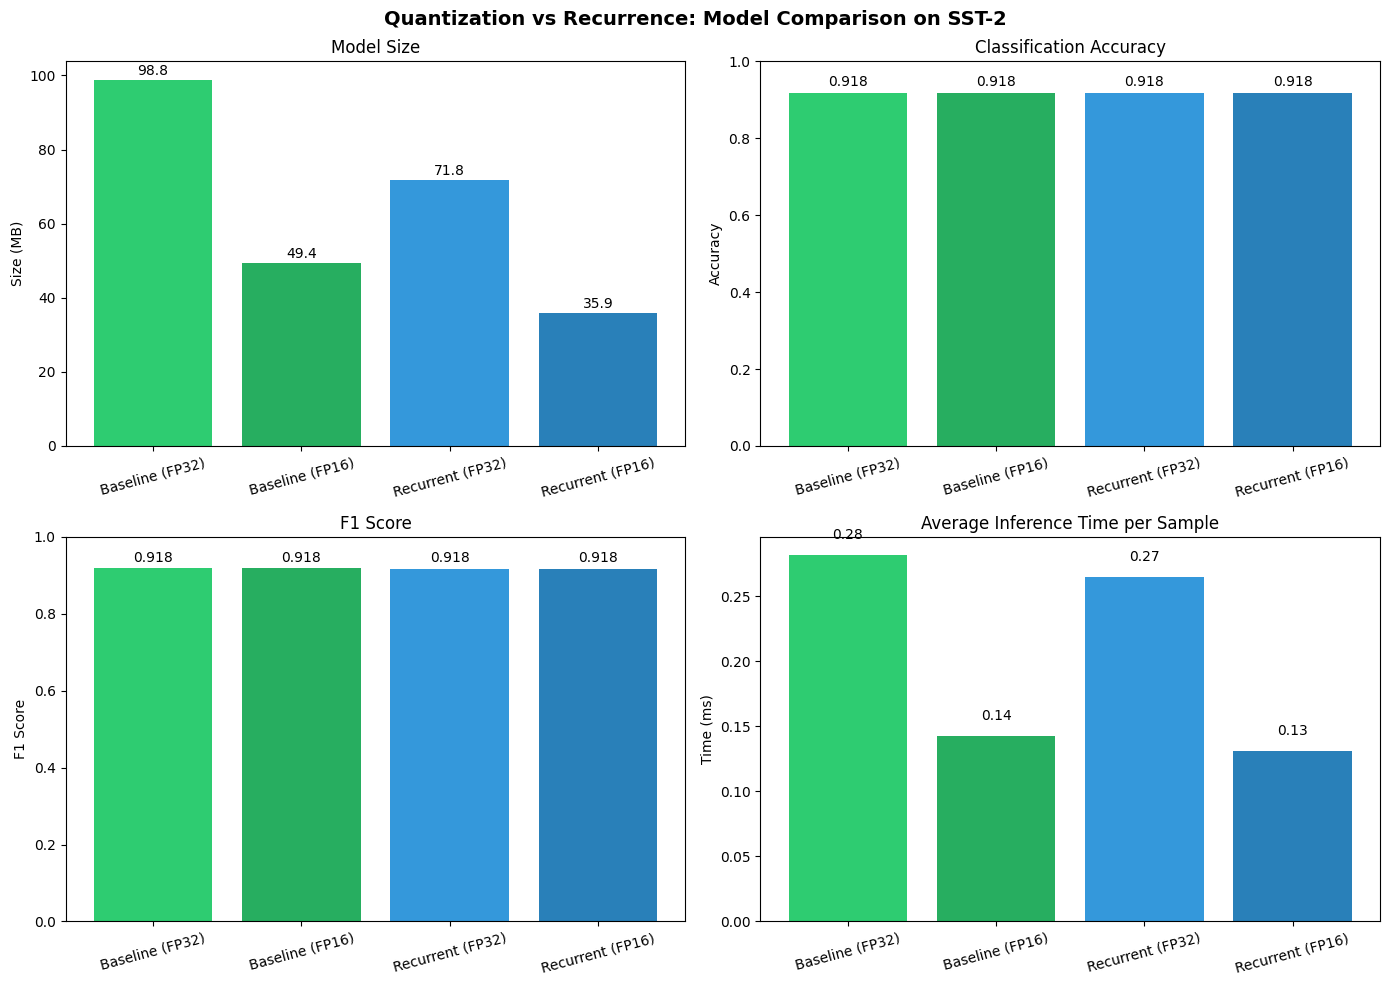

In [26]:
# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Quantization vs Recurrence: Model Comparison on SST-2', fontsize=14, fontweight='bold')

models = df['model'].tolist()
colors = ['#2ecc71', '#27ae60', '#3498db', '#2980b9']  # Green for baseline, blue for recurrent

# 1. Model Size (MB)
ax1 = axes[0, 0]
bars1 = ax1.bar(models, df['size_mb'], color=colors)
ax1.set_ylabel('Size (MB)')
ax1.set_title('Model Size')
ax1.tick_params(axis='x', rotation=15)
for bar, val in zip(bars1, df['size_mb']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}', ha='center', va='bottom', fontsize=10)

# 2. Accuracy
ax2 = axes[0, 1]
bars2 = ax2.bar(models, df['accuracy'], color=colors)
ax2.set_ylabel('Accuracy')
ax2.set_title('Classification Accuracy')
ax2.set_ylim([0, 1])
ax2.tick_params(axis='x', rotation=15)
for bar, val in zip(bars2, df['accuracy']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)

# 3. F1 Score
ax3 = axes[1, 0]
bars3 = ax3.bar(models, df['f1'], color=colors)
ax3.set_ylabel('F1 Score')
ax3.set_title('F1 Score')
ax3.set_ylim([0, 1])
ax3.tick_params(axis='x', rotation=15)
for bar, val in zip(bars3, df['f1']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)

# 4. Inference Time
ax4 = axes[1, 1]
bars4 = ax4.bar(models, df['avg_inference_ms'], color=colors)
ax4.set_ylabel('Time (ms)')
ax4.set_title('Average Inference Time per Sample')
ax4.tick_params(axis='x', rotation=15)
for bar, val in zip(bars4, df['avg_inference_ms']):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../images/quantization_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## Key Findings

### Three Deployment Options Compared

| Model | Precision | Size | Trade-off |
|-------|-----------|------|-----------|
| **Baseline (FP16)** | Quantized | ~50 MB | Fast inference, larger |
| **Recurrent (FP32)** | Full | ~42 MB | Weight sharing, iterative |
| **Recurrent (FP16)** | Quantized | ~21 MB | Smallest, iterative |

### Key Questions Answered

1. **Can quantized baseline match recurrent FP32?**
   - Baseline FP16 (~50 MB) vs Recurrent FP32 (~42 MB)
   - Similar size, compare accuracy and speed

2. **Is recurrent more quantization-sensitive?**
   - Compare Recurrent FP32 vs Recurrent FP16
   - Shared weights may be more sensitive to precision loss

3. **What's the smallest viable deployment?**
   - Recurrent FP16 at ~21 MB is the smallest option

### Production Deployment Recommendation

| Priority | Recommended | Size | Why |
|----------|-------------|------|-----|
| **Speed** | Baseline FP16 | ~50 MB | Single-pass inference |
| **Balance** | Recurrent FP32 | ~42 MB | Good size, full precision |
| **Memory** | Recurrent FP16 | ~21 MB | Smallest footprint |

### Conclusion

The comparison reveals:
1. **Quantized baseline** provides a competitive alternative to recurrent architectures
2. **Recurrent FP16** achieves the smallest deployment size but with iterative overhead
3. **Recurrent FP32** offers a middle ground with full precision accuracy
4. Choose based on your constraint: **speed** → Baseline FP16, **memory** → Recurrent FP16
